In [3]:
%%capture
import radd
from radd import build
from radd.tools import vis
%matplotlib inline

In [8]:
from os import path
import pandas as pd
_homedir = path.expanduser('~')
coxon_data_dir = path.join(_homedir, "Dropbox/Projects/Coxon/coxon_behav_data.csv")
coxon_data = pd.read_csv(coxon_data_dir)

# initiate dependent process model with dynamic gain (kind = 'xdpm')
# (change kind='dpm' for model with no dynamic gain signal)
# drift-rate (v) depends on Baseline and Caution levels of 'Cond' variable
# model = build.Model(kind='xdpm', data=coxon_data, depends_on={'v':'Cond'}, fit_on='average')

# initiate independent race model with dynamic gain (kind = 'xirace')
model = build.Model(kind='xirace', data=coxon_data, depends_on={'v':'Cond'}, fit_on='average')

## Animation of Dependent Process Model

In [245]:
# Initial state of Stop process (red) depends on current strength of Go activation (green)
# Assumes Stop signal efficacy at later SSDs diminishes as the state of the Go process 
# approaches the execution threshold (upper bound). pink lines denote t=SSD, blue is trial deadline
radd.load_dpm_animation()

### columns in model's observed dataframe (model.observedDF)
* **idx**: subject ID
* **Cond**: Baseline(bsl)/Caution(pnl) (could be any experimental condition of interest) 
* **Acc**: Accuracy on "go" trials
* **sacc**: Mean accuracy on "stop" trials (mean condition SSD used during simulations)
* **c10 - c90**: 10th - 90th RT quantiles for correct responses
* **e10 - e90**: 10th - 90th RT quantiles for error responses

In [9]:
model.observedDF.head()

,idx,Cond,acc,sacc,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,1,pro,1.0,0.52500,0.76784,0.79500,0.8095,0.82400,0.84916,0.76066,0.77700,0.7895,0.80356,0.82402
1,1,reac,1.0,0.51613,0.76300,0.78300,0.7960,0.81634,0.84000,0.75642,0.76746,0.7850,0.79854,0.81216
2,2,pro,1.0,0.48750,0.78442,0.80200,0.8150,0.83500,0.85158,0.76300,0.78600,0.7970,0.81100,0.82200
3,2,reac,1.0,0.46774,0.78200,0.79800,0.8070,0.81914,0.83600,0.76500,0.77900,0.7890,0.80722,0.82800
4,3,pro,1.0,0.50000,0.77282,0.79366,0.8130,0.83500,0.86200,0.75310,0.78300,0.7945,0.81754,0.84812


### Optimize DPM to the average data (drift-rate free across levels of "Cond") 

default inits: fmin = 1.049439907
basinhopping step 0: f 0.0130296
basinhopping step 1: f 0.108857 trial_f 0.108857 accepted 1  lowest_f 0.0130296
basinhopping step 2: f 0.15832 trial_f 0.15832 accepted 1  lowest_f 0.0130296
basinhopping step 3: f 1.57119 trial_f 1.57119 accepted 1  lowest_f 0.0130296
basinhopping step 4: f 1.52223 trial_f 1.52223 accepted 1  lowest_f 0.0130296
basinhopping step 5: f 0.307779 trial_f 0.307779 accepted 1  lowest_f 0.0130296
basinhopping step 6: f 0.366577 trial_f 0.366577 accepted 1  lowest_f 0.0130296
basinhopping step 7: f 0.434474 trial_f 0.434474 accepted 1  lowest_f 0.0130296
basinhopping step 8: f 0.293931 trial_f 0.293931 accepted 1  lowest_f 0.0130296
basinhopping step 9: f 1.69497 trial_f 1.69497 accepted 1  lowest_f 0.0130296
adaptive stepsize: acceptance rate 0.900000 target 0.500000 new stepsize 0.111111 old stepsize 0.1
basinhopping step 10: f 1.56013 trial_f 1.56013 accepted 1  lowest_f 0.0130296
basinhopping step 11: f 1.50217 trial_f 1.5

/Users/kyle/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


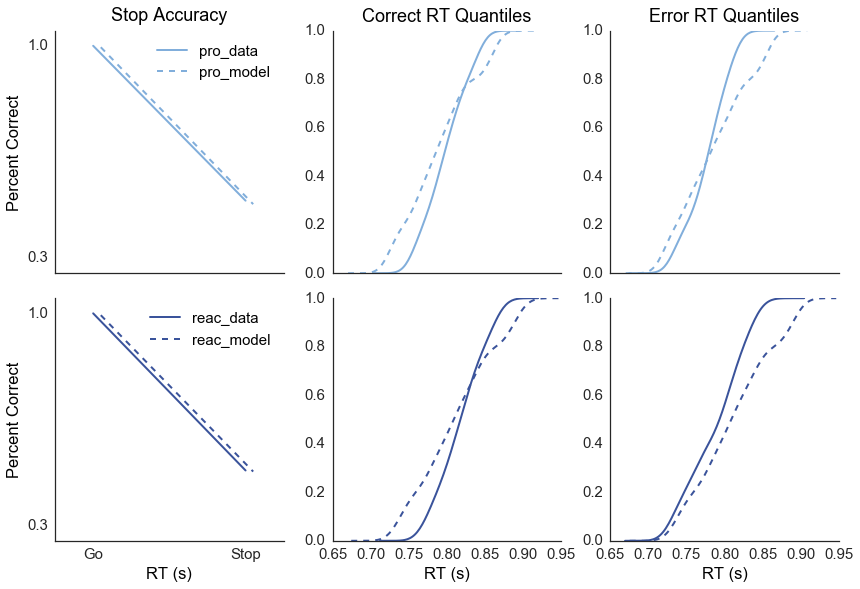

In [10]:
# Set basinhopping step-size to .1 (see HopStep class in radd.fit 
# and get_stepsize_scalars function in radd.tools.theta). 
# Sample 5000 possible parameters sets, perform global opt on best 3. 
# Set disp=False to perform optimization quietly. 
model.set_basinparams(stepsize=.1, nrand_samples=5000, nrand_inits=3)#, disp=False)

# fit DPM using combination of global (basinhopping + TNC)
# and local gradient optimization (Nelder-Mead Simplex)
model.optimize(plot_fits=True)

## if fits don't look great you can try a few different things

* increasing size of the parameters search and setting more conservative convergence criteria 
     * model.set_basinparams(niter_success=50, tol=1e6, nrand_inits=10, nrand_samples=10000, stepsize=.15) 
     * model.set_fitparams(maxfev=5000, tol=1e-6)

* Fits can also get thrown off if the cost_fx weights are unreasonable the following methods show vectors of weights applied to each value in the cost function or in other words, each column in the model.observerdDF. 
    * all models are initially fit to a flat data vector, weighted by an equal length array of weights estimated as the inverse of the measured uncertainty in each observed data point (flat meaning single-dimensional vector, collapsing across conditions)
    * if the user supplies a **depends_on** dictionary when instantiating the model (see above), then all parameters from the initial (flat) fit are held constant except for the parameter in **depends_on.keys()** which is free to vary across levels of the condition in **depends_on.values()**. 
    * For instance, to fit a model with drift-rate free to vary across levels of 'Cond' (column in the data)            
        * depends_on = {'v': 'Cond'} 
   

* for **model** with **fit_on** = 'average' and **depends_on** = {**param** : **condition**}

|model information | method used to calculate | how to access|
|--|--|--|
| flat data | **model**.observedDF.mean() | **model**.observed_flat |
| flat weights | **model**.wtsDF.mean() | **model**.flat_wts |
| conditional data | **model**.observedDF.groupby(**condition**).mean()| **model**.observed |
| conditional weights | **model**.wtsDF.groupby(**condition**).mean() |  **model**.cond_wts |

* if fits are wonky, check out the wts vectors to see if any contain extreme values
* try re-running the fits with an unweighted model (all wts = 1) 
    * m = build.Model(data=data, ... weighted=False)


In [12]:
model.yhatDF

,idx,Cond,acc,sacc,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,average,pro,0.99525,0.4778,0.73878,0.77878,0.80878,0.83878,0.89378,0.73378,0.76878,0.80378,0.83878,0.88878
1,average,reac,0.99395,0.4783,0.73878,0.77878,0.80878,0.83878,0.88878,0.73878,0.77878,0.80878,0.83878,0.88878


## Examine fits
* txt summary of the fit results are saved to the working dir 

In [326]:
# the fit summary (goodness of fit measures, etc.) 
model.fitDF

idx,average
a,0.49908
ssv,-1.2777
tr,0.39246
xb,1.5052
v_pro,0.94778
v_reac,0.96441
nfev,1075
nvary,2
df,22
chi,0.001633


In [321]:
# model predictions
# to save as csv file: model.yhatDF.to_csv("path_where_you_want_to_save_to", index=False)
# to extract values as numpy ndarray: model.yhatDF.loc[:, 'acc':].values
model.yhatDF

,idx,Cond,acc,sacc,c10,c30,c50,c70,c90,e10,e30,e50,e70,e90
0,average,pro,1.0,0.4790,0.78137,0.80637,0.81637,0.83637,0.86137,0.77137,0.79137,0.80137,0.80637,0.83637
1,average,reac,1.0,0.5186,0.78137,0.80137,0.81637,0.83637,0.86137,0.77137,0.79137,0.80137,0.80637,0.82637


In [327]:
# best-fit parameter estimates also stored in popt dictionary
model.popt

{'a': 0.49908413581994382,
 'ssv': -1.2777324504102632,
 'tr': 0.39245545758723105,
 'v': array([ 0.94778,  0.96441]),
 'v_pro': 0.94777748486210922,
 'v_reac': 0.96440778554936757,
 'xb': 1.5052117872193238}

In [20]:
def css_styling():
    import radd
    from IPython.core.display import HTML
    css_path = os.path.join(radd._examples_dir, 'custom.css')
    styles = open(css_path, "r").read()
    return HTML(styles)
css_styling()